## Linear Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

%matplotlib inline

# Import the models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import datetime 
from datetime import date, timedelta
import yfinance as yf

start_date = datetime.datetime(2015, 1, 1)
end_date  = datetime.datetime(2023, 8, 23)

stock_name = "GOOGL"

my_stocks = yf.download(tickers = ["GOOGL", "PANW", "AMZN", "BUD", "AAPL", "MSFT", "GME", "TSLA", "NFLX", "META", "WMT", "WBA", "NVDA"]
, start=start_date, end=end_date, group_by='tickers')
my_df = my_stocks[stock_name]
my_df

[*********************100%%**********************]  13 of 13 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,26.629999,26.790001,26.393999,26.477501,26.477501,26480000
2015-01-05,26.357500,26.399500,25.887501,25.973000,25.973000,41182000
2015-01-06,26.025000,26.060499,25.277500,25.332001,25.332001,54456000
2015-01-07,25.547501,25.574499,25.182501,25.257500,25.257500,46918000
2015-01-08,25.075500,25.375000,24.750999,25.345501,25.345501,73054000
...,...,...,...,...,...,...
2023-08-16,128.699997,130.279999,127.870003,128.699997,128.699997,25216100
2023-08-17,129.800003,131.990005,129.289993,129.919998,129.919998,33446300
2023-08-18,128.509995,129.250000,126.379997,127.459999,127.459999,30491300


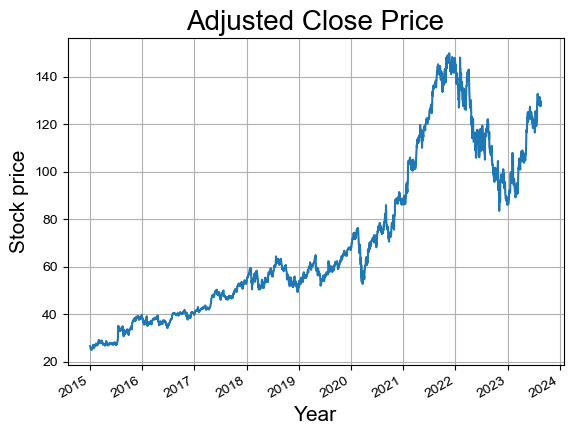

In [3]:
my_df['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(15, 9)})
plt.title('Adjusted Close Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15);

## Feature Engineering

In [4]:
forecast_out = 30
df_adj = my_df[['Adj Close']]
df_adj 
# Create column for target variable shifted 'n' days up
df_adj['Prediction'] = df_adj[['Adj Close']].shift(-forecast_out)
df_adj

/var/folders/b_/qpl3sp4n7_55mr2n2w20rmh40000gn/T/ipykernel_17785/2618080003.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adj['Prediction'] = df_adj[['Adj Close']].shift(-forecast_out)


,Adj Close,Prediction
Date,,
2015-01-02,26.477501,27.2505
2015-01-05,25.973000,27.1325
2015-01-06,25.332001,27.3225
2015-01-07,25.257500,27.0900
2015-01-08,25.345501,26.7500
...,...,...
2023-08-16,128.699997,NaN
2023-08-17,129.919998,NaN
2023-08-18,127.459999,NaN


In [5]:
X = np.array(df_adj.drop(['Prediction'], 1))
# Remove last 'n' rows
X = X[:-forecast_out]
print(X)

[[ 26.47750092]
 [ 25.97299957]
 [ 25.33200073]
 ...
 [119.48000336]
 [116.44999695]
 [117.13999939]]


/var/folders/b_/qpl3sp4n7_55mr2n2w20rmh40000gn/T/ipykernel_17785/666560682.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(df_adj.drop(['Prediction'], 1))


In [6]:
y = np.array(df_adj['Prediction'])
# Remove last 'n' rows
y = y[:-forecast_out]

print(y)

[ 27.25049973  27.13249969  27.32250023 ... 127.45999908 128.36999512
 129.08000183]


In [7]:
train_size = int(X.shape[0]*0.7)

X_train = X[0:train_size]
y_train = y[0:train_size]

X_test = X[train_size:]
y_test = y[train_size:]


In [8]:
models = {
    "Linear": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "ElasticNet": ElasticNet(),
    "KNN": KNeighborsRegressor(),
    "DecisionTree": DecisionTreeRegressor(),
    "SVR": SVR(kernel='rbf', C=1e3, gamma='scale'),
    "AdaBoost": AdaBoostRegressor(),
    "GradientBoost": GradientBoostingRegressor(),
    "RandomForest": RandomForestRegressor(),
    "ExtraTrees": ExtraTreesRegressor(),
    "BaggingRegressor": BaggingRegressor(),
    "XGBRegressor": XGBRegressor(objective='reg:squarederror'),
    "MLPRegressor": MLPRegressor(solver='lbfgs')
}

In [9]:
model_results = []  
model_names   = []
for model_name in models:
    model = models[model_name]
    tscv = TimeSeriesSplit(n_splits=7)
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    model_results.append(cv_results)
    model_names.append(model_name)
    print("{}: {}, ({})".format(model_name, round(cv_results.mean(), 6), round(cv_results.std(), 6)))
     


Linear: -0.523369, (0.422167)
Lasso: -0.690634, (0.600254)
Ridge: -0.523553, (0.422226)
ElasticNet: -0.65639, (0.545515)
KNN: -4.639627, (4.56279)
DecisionTree: -4.58743, (3.72172)
SVR: -19.833483, (15.963155)
AdaBoost: -3.960094, (4.057676)
GradientBoost: -4.265273, (3.831506)
RandomForest: -4.502536, (4.058656)
ExtraTrees: -4.470397, (3.766624)
BaggingRegressor: -4.4215, (3.80532)
XGBRegressor: -4.435183, (3.750185)
MLPRegressor: -0.524409, (0.421209)


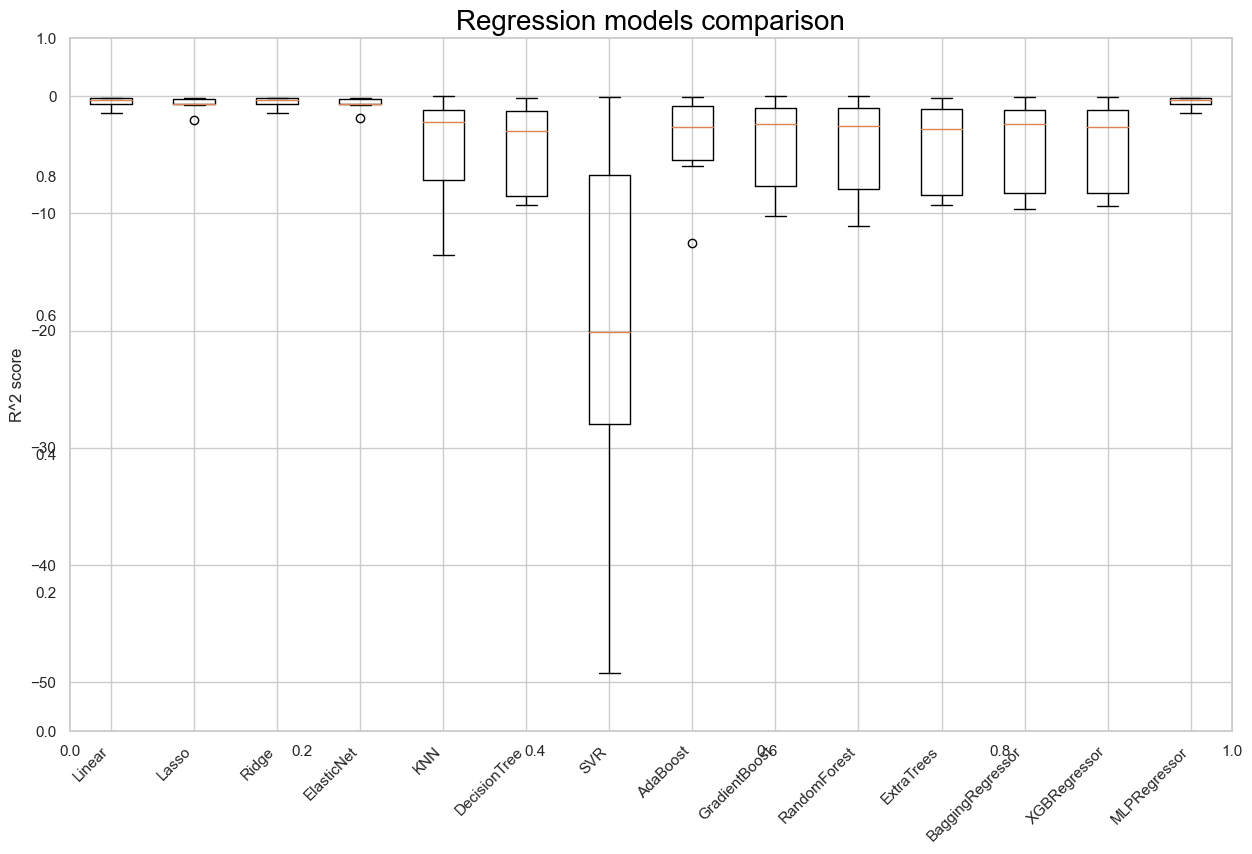

In [10]:
def box_compare():
  sns.set(rc={'figure.figsize':(15, 9)})
  sns.set_style(style='whitegrid', )
  figure = plt.figure()
  plt.title('Regression models comparison', color = 'black', fontsize = 20)
  axis = figure.add_subplot(111)
  plt.boxplot(model_results)
  axis.set_xticklabels(model_names, rotation = 45, ha="right")
  axis.set_ylabel("R^2 score")
  plt.margins(0.05, 0.1)

box_compare()
     

Coefficients:  [0.9912276]
RMSE: 10.293
R^2 score: 0.634


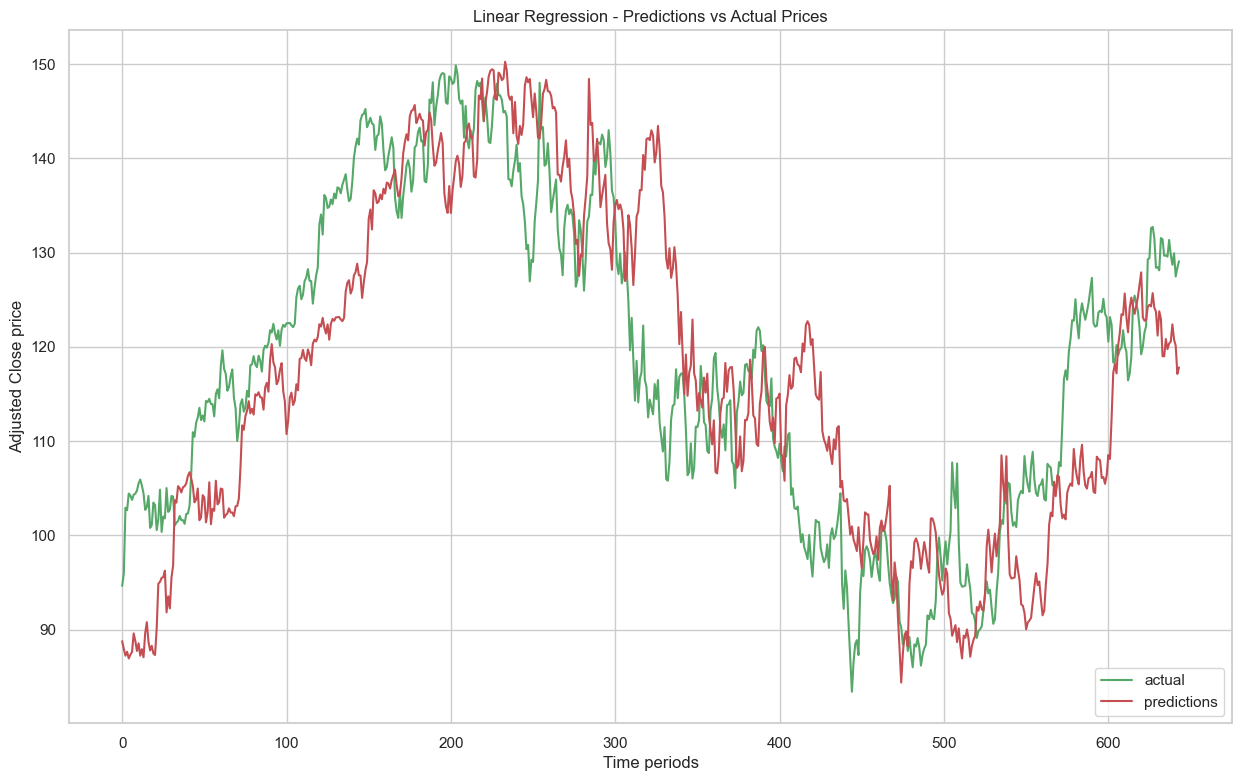

In [11]:

# Create Linear Regression model
lr = LinearRegression()

# Train the model
lr.fit(X_train, y_train)

predictions = lr.predict(X_test)


# The coefficients
print('Coefficients: ', lr.coef_)
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(y_test, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(y_test, predictions), 3)))

x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, y_test, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('Linear Regression - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

## Comparision between Predicted and Actual price

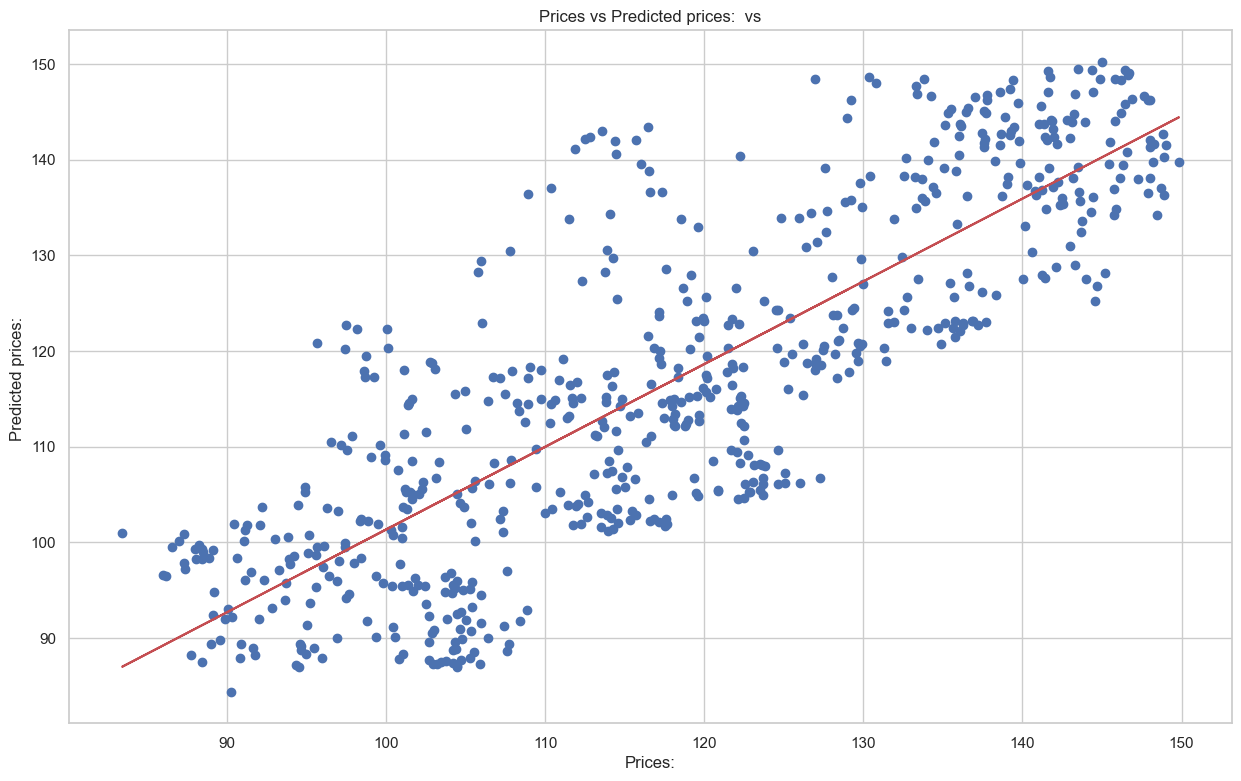

In [14]:
pd.DataFrame({"Actual": y_test, "Predict": predictions}).head()

# create basic scatterplot
plt.scatter(y_test,predictions)

# obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(y_test, predictions, 1)

# add linear regression line to scatterplot 
plt.plot(y_test, m*y_test+b, c='r')

plt.xlabel("Prices:")
plt.ylabel("Predicted prices: ")
plt.title("Prices vs Predicted prices:  vs")
plt.show()

In [16]:
next_vals = np.array(df_adj.drop(['Prediction'],1))[-forecast_out:]
lr_prediction = lr.predict(next_vals)
print(lr_prediction)

[119.58778199 125.14856943 126.02084699 125.25760507 124.37541311
 122.66058604 119.85541012 120.66821645 122.16497224 122.83900731
 129.83707929 129.9659286  133.11804022 133.25681148 132.09707701
 128.95488734 129.0242654  128.68725165 132.07724822 131.94838379
 130.22365745 130.25339307 130.12452864 131.87900573 130.34259992
 129.2720723  130.48137118 128.0429522  128.94496538 129.64874363]


/var/folders/b_/qpl3sp4n7_55mr2n2w20rmh40000gn/T/ipykernel_17785/1331344705.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  next_vals = np.array(df_adj.drop(['Prediction'],1))[-forecast_out:]


## Evaluate the models

In [18]:
# The coefficients
print('Coefficients: ', lr.coef_)
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(next_vals, lr_prediction, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(next_vals, lr_prediction), 3)))

Coefficients:  [0.9912276]
RMSE: 0.585
R^2 score: 0.979


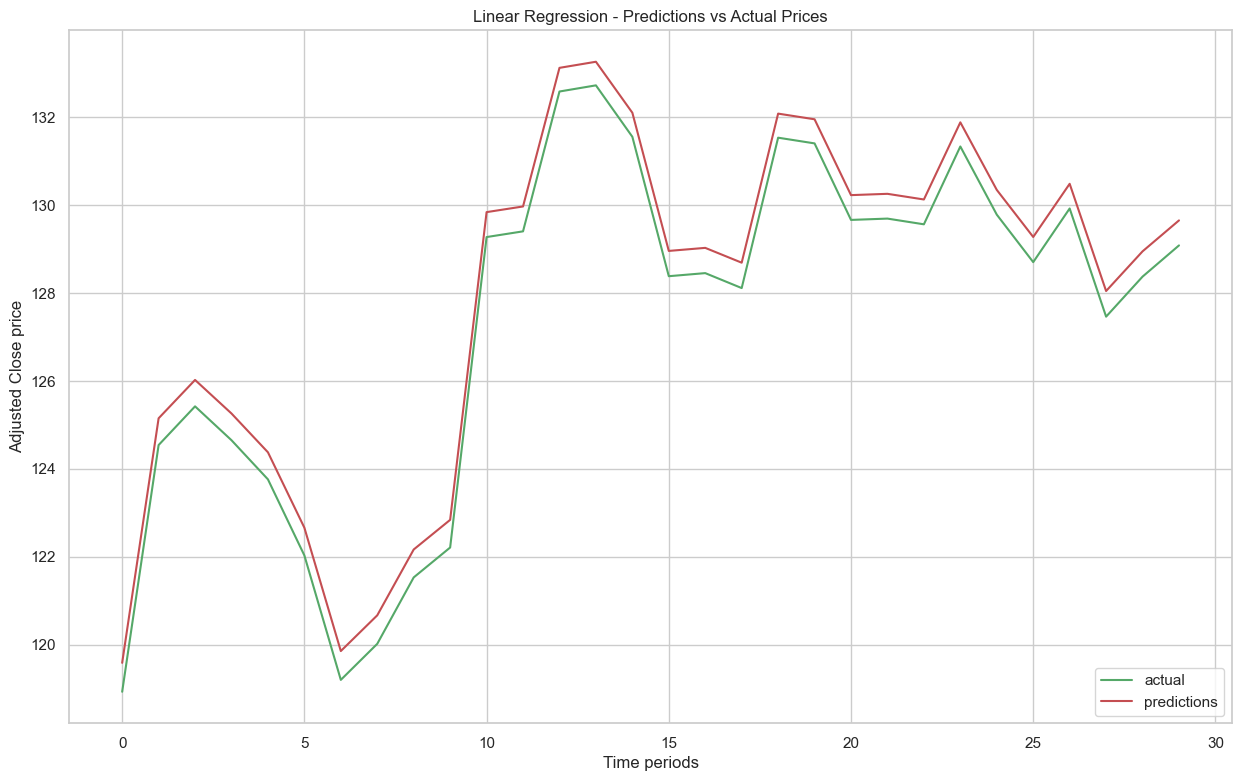

In [19]:
# Plot predictions against actual Adjusted Close prices 

x_axis = np.array(range(0, lr_prediction.shape[0]))
plt.plot(x_axis, next_vals, color='g', label="actual")
plt.plot(x_axis, lr_prediction, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('Linear Regression - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()

In [20]:
X_forecast = next_vals.reshape(-1)
X_forecast 

array([118.93000031, 124.54000092, 125.41999817, 124.65000153,
       123.76000214, 122.02999878, 119.19999695, 120.01999664,
       121.52999878, 122.20999908, 129.27000427, 129.3999939 ,
       132.58000183, 132.72000122, 131.55000305, 128.38000488,
       128.44999695, 128.11000061, 131.52999878, 131.3999939 ,
       129.66000366, 129.69000244, 129.55999756, 131.33000183,
       129.77999878, 128.69999695, 129.91999817, 127.45999908,
       128.36999512, 129.08000183])

## Finding the optimized parameters

In [22]:
parameters = {'normalize': [True, False], 'fit_intercept': [True, False],
         'n_jobs': [None, -1]}


In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

parameters = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
}

lr = LinearRegression()

gridsearchcv_lr = GridSearchCV(estimator=lr, param_grid=parameters, cv=tscv, scoring='r2')
grid_result_lr = gridsearchcv_lr.fit(X_train, y_train)
print("Best: {} using {}".format(grid_result_lr.best_score_, grid_result_lr.best_params_))


Best: -0.5233694849382492 using {'copy_X': True, 'fit_intercept': True, 'positive': True}


In [27]:
# Reshape data to be 2D
X_forecast = X_forecast.reshape(-1, 1)

# Create Linear Regression model
lr = LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None)

# Train the model using the training sets
lr.fit(X_train, y_train)

# Make predictions using the model
predictions = lr.predict(X_forecast)

# The coefficients
print('Coefficients: ', lr.coef_)
# The mean squared error
print('RMSE: {}'.format(round(mean_squared_error(X_forecast, predictions, squared=False), 3)))
# Explained variance score: 1 is perfect prediction, 0 is random
print('R^2 score: {}'.format(round(r2_score(X_forecast, predictions), 3)))


Coefficients:  [1.02216091]
RMSE: 2.823
R^2 score: 0.502


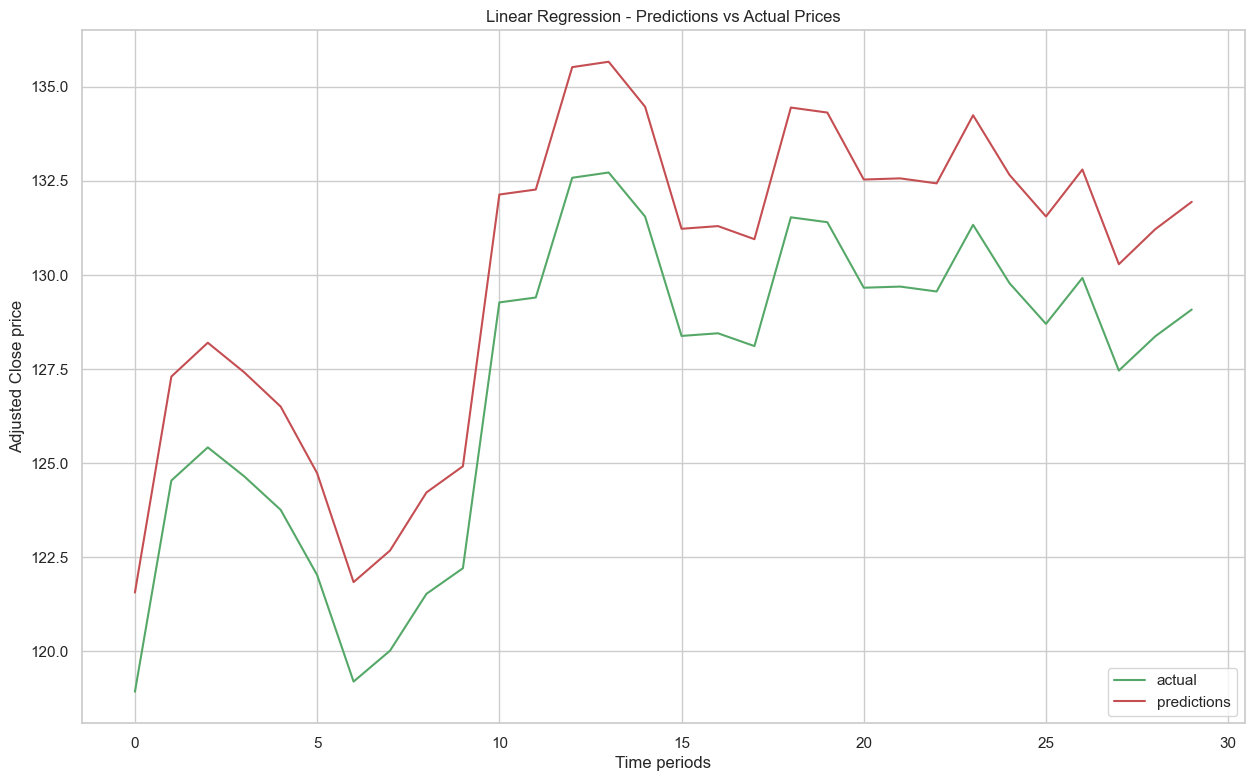

In [28]:
x_axis = np.array(range(0, predictions.shape[0]))
plt.plot(x_axis, X_forecast, color='g', label="actual")
plt.plot(x_axis, predictions, color='r', label="predictions")
plt.xlabel('Time periods')
plt.ylabel('Adjusted Close price')
plt.title('Linear Regression - Predictions vs Actual Prices')
plt.legend(loc='lower right')
plt.show()
     